#### Clone the DoDUO repository, fetch the data , install the packages

In [ ]:
!git clone https://github.com/megagonlabs/doduo

In [ ]:
%cd doduo

In [ ]:
!bash download.sh

In [ ]:
!pip install transformers -q
!pip install sentencepiece -q

#### Import Modules

In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import re
import pickle
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from tqdm.notebook import tqdm
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    classification_report
)
import random
from transformers import (
    T5Tokenizer, 
    T5Model,
    T5ForConditionalGeneration,
    get_linear_schedule_with_warmup,
    get_constant_schedule_with_warmup
)

from transformers.models.auto.processing_auto import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
from pandas.errors import SettingWithCopyWarning
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import locale
locale.getpreferredencoding = lambda: "UTF-8"

##### Preprocessing Functions

In [ ]:
def create_map_dict_for_labels(temp_df):
  '''
  Create dictionaries to map the values with labels
  '''

  # Create an instance of MultiLabelBinarizer
  mlb = MultiLabelBinarizer()
  # Fit the MultiLabelBinarizer to the data and transform the column of lists
  one_hot = pd.DataFrame(mlb.fit_transform(temp_df['labels']), columns=mlb.classes_, index=temp_df.index)

  my_dict= {}
  for i,l in enumerate(one_hot.columns):
    my_dict[i]= l

  my_inv_dict = {v: k for k, v in my_dict.items()}
  
  return my_dict , my_inv_dict


def create_map_dict_for_labels_ann(temp_df):
  '''
  Create dictionaries to map the values with labels
  '''

  # Create an instance of MultiLabelBinarizer
  mlb = MultiLabelBinarizer()
  # Fit the MultiLabelBinarizer to the data and transform the column of lists
  one_hot = pd.DataFrame(mlb.fit_transform(temp_df['labels']), columns=mlb.classes_, index=temp_df.index)

  my_dict= {}
  for i,l in enumerate(one_hot.columns):
    my_dict[i+300]= l

  my_inv_dict = {v: k for k, v in my_dict.items()}
  
  return my_dict , my_inv_dict

def given_list(temp,my_inv_dict):
  new_list = []
  for t in temp:
    new_list.append(str(my_inv_dict.get(t)))
  return new_list


def flatten_dataframe_to_list(train_df,val_df,temp_my_inv_dict):
  '''
  flatten both data and labels to list with the respective dataframes
  as well as do necessary preprocessing actions
  '''
  train_label_list = []
  val_label_list = []
  train_data_list = []
  val_data_list = []

  train_temp_label_list = train_df.labels.tolist()
  for t in train_temp_label_list:
    if len(t)==1:
      train_label_list.append(str(temp_my_inv_dict.get(t[0])) + ' </s>')
    else:
      train_label_list.append(' , '.join( given_list(t,temp_my_inv_dict) ) + ' </s>')


  val_temp_label_list = val_df.labels.tolist()
  for t in val_temp_label_list:
    if len(t)==1:
      val_label_list.append(str(temp_my_inv_dict.get(t[0])) + ' </s>')
    else:
      val_label_list.append(' , '.join( given_list(t,temp_my_inv_dict) ) + ' </s>')

  temp_train_data_list = train_df.data.tolist()
  for t in temp_train_data_list:
    texty = t.lower().replace('\n', ' ').replace('\t', ' ')
    texty = re.sub('([.,!?()])', r' \1 ', texty)
    train_data_list.append('multilabel classification: ' + texty)

  temp_val_data_list = val_df.data.tolist()
  for t in temp_val_data_list:
    texty = t.lower().replace('\n', ' ').replace('\t', ' ')
    texty = re.sub('([.,!?()])', r' \1 ', texty)
    val_data_list.append('multilabel classification: ' + texty)

  return  train_label_list , val_label_list , train_data_list ,val_data_list 


def calculate_colpair_relationships(temp_df,temp_my_inv_dict):
  '''
  With respect to a df, flatten it to list
  fetching as well the colpair relationships
  '''
  data_list_concat = []
  labels_list_concat = []
  final_data_list = []
  final_label_list = []

  for (index, group_df) in temp_df.groupby('table_id'):
    total_rows , total_cols = group_df.shape
    data_list = group_df.data.values.tolist()
    labels_list = group_df.new_labels.values.tolist()
    for i,d in enumerate(data_list):
      if i == total_rows -1:
        break
      else:
        data_list_concat.append(' </s> '.join(data_list[i:i+2]))
    for i,d in enumerate(labels_list):
      if i==0:
        labels_list_concat.append(labels_list[1] + ' </s>')    
      elif i == total_rows -1:
        break
      else:
        labels_list_concat.append(labels_list[i+1]+ ' </s>')

  for t in data_list_concat:
    texty = t.lower().replace('\n', ' ').replace('\t', ' ')
    texty = re.sub('([.,!?()])', r' \1 ', texty)
    final_data_list.append('multilabel classification: ' + texty)

  for t in labels_list_concat:
    split_list = t.split(' ')
    final_label_list.append(mul_given_list(split_list,temp_my_inv_dict))
  
  return final_data_list , final_label_list


def mul_given_list(temp,my_inv_dict):
  '''
  With respect to a give list - replace the element
  with the value of my_inv_dict
  '''
  new_list = []
  for t in temp:
    if t in my_inv_dict.keys():
      new_list.append(str(my_inv_dict.get(t)))
    else:
      new_list.append(t)
  return ' '.join(new_list)

##### Preprocessing Classes

In [ ]:
class Config:
    def __init__(self):
        super(Config, self).__init__()
        self.SEED = 42
        self.MODEL_PATH = 't5-base'
        self.TOKENIZER = T5Tokenizer.from_pretrained('google/mt5-small')
        self.SRC_MAX_LENGTH = 180
        self.TGT_MAX_LENGTH = 50
        self.BATCH_SIZE = 16
        self.VALIDATION_SPLIT = 0.25
        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.FULL_FINETUNING = False
        self.LR = 2e-5
        self.OPTIMIZER = 'AdamW'
        self.CRITERION = 'BCEWithLogitsLoss'
        self.SAVE_BEST_ONLY = True
        self.N_VALIDATE_DUR_TRAIN = 3
        self.OUTPUT_PATH = '/content/T5model_single_column_MTL.pt'
        self.EPOCHS = 10

In [ ]:
class T5Dataset(Dataset):
    def __init__(self, texts,labels):
        super(T5Dataset, self).__init__()
        self.texts = texts
        self.labels = labels
        self.tokenizer = config.TOKENIZER
        self.src_max_length = config.SRC_MAX_LENGTH
        self.tgt_max_length = config.TGT_MAX_LENGTH

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        src_tokenized = self.tokenizer.encode_plus(
            self.texts[index], 
            max_length=self.src_max_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        src_input_ids = src_tokenized['input_ids'].squeeze()
        src_attention_mask = src_tokenized['attention_mask'].squeeze()

        tgt_tokenized = self.tokenizer.encode_plus(
            self.labels[index], 
            max_length=self.tgt_max_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        tgt_input_ids = tgt_tokenized['input_ids'].squeeze()
        tgt_attention_mask = tgt_tokenized['attention_mask'].squeeze()

        return {
            'src_input_ids': src_input_ids.long(),
            'src_attention_mask': src_attention_mask.long(),
            'tgt_input_ids': tgt_input_ids.long(),
            'tgt_attention_mask': tgt_attention_mask.long()
        }



#### Data Preprocessing

##### Dataset & Dataloaders of Relationship Data

In [ ]:
config = Config()

# load the data 
with open('/content/doduo/data/table_rel_extraction_serialized.pkl', 'rb') as f:
    all_data_re = pickle.load(f)

train_df_re = all_data_re.get('train')
val_df_re = all_data_re.get('dev')
whole_df_re = all_data_re.get('train')


train_df_re['new_labels'] = train_df_re['labels'].apply(lambda x:  ' , '.join(x))
val_df_re['new_labels'] = val_df_re['labels'].apply(lambda x:  ' , '.join(x))

print('Train Dataframe rows : {} and columns : {}'.format(train_df_re.shape[0],train_df_re.shape[1]))
print('Validation Dataframe rows : {} and columns : {}'.format(val_df_re.shape[0],val_df_re.shape[1]))

# create a dictionary (and inverse) with respect to labels of df
my_dict_re , my_inv_dict_re = create_map_dict_for_labels(whole_df_re)

for key,value in my_dict_re.items():
  print(key , value)

train_data_list_re , train_label_list_re = calculate_colpair_relationships(train_df_re,my_inv_dict_re)
val_data_list_re , val_label_list_re = calculate_colpair_relationships(val_df_re,my_inv_dict_re)

# Initiate T5Datasets as well as Dataloader with respect to data & label lists

train_data_re = T5Dataset(texts=train_data_list_re, labels=train_label_list_re)
train_dataloader_re = DataLoader(train_data_re, batch_size=config.BATCH_SIZE,shuffle=True)

val_data_re = T5Dataset(texts=val_data_list_re, labels=val_label_list_re)
val_dataloader_re = DataLoader(val_data_re, batch_size=config.BATCH_SIZE,shuffle=True)

Train Dataframe rows : 115897 and columns : 6
Validation Dataframe rows : 3735 and columns : 6
0 american_football.football_player.games-american_football.player_game_statistics.team
1 american_football.football_player.position_s
2 aviation.airline.hubs
3 aviation.airport.serves
4 award.award_category.category_of
5 award.award_category.nominees-award.award_nomination.award_nominee
6 award.award_category.nominees-award.award_nomination.ceremony
7 award.award_category.winners-award.award_honor.award_winner
8 award.award_category.winners-award.award_honor.ceremony
9 award.award_ceremony.awards_presented-award.award_honor.award_winner
10 award.award_ceremony.awards_presented-award.award_honor.honored_for
11 award.award_ceremony.nominees-award.award_nomination.award_nominee
12 award.award_ceremony.nominees-award.award_nomination.nominated_for
13 award.award_nominated_work.award_nominations-award.award_nomination.award_nominee
14 award.award_nominated_work.award_nominations-award.award_nomin

##### Dataset & Dataloaders of Annotation Data

In [ ]:
# load the data 
with open('/content/doduo/data/table_col_type_serialized.pkl', 'rb') as f:
    all_data_ann = pickle.load(f)

# define a threshold for the training & validation data
train_data_threshold = 150000
validation_data_threshold = 3000


train_df_ann = all_data_ann.get('train').head(train_data_threshold)
val_df_ann = all_data_ann.get('dev').head(validation_data_threshold)
whole_df_ann = all_data_ann.get('train')

# create a dictionary (and inverse) with respect to labels of df
my_dict_ann , my_inv_dict_ann = create_map_dict_for_labels_ann(whole_df_ann)

for key,value in my_dict_ann.items():
  print(key , value)

train_label_list_ann, val_label_list_ann, train_data_list_ann, val_data_list_ann =  flatten_dataframe_to_list(train_df_ann,val_df_ann,my_inv_dict_ann)

# Initiate T5Datasets as well as Dataloader with respect to data & label lists

train_data_ann = T5Dataset(texts=train_data_list_ann, labels=train_label_list_ann)
train_dataloader_ann = DataLoader(train_data_ann, batch_size=config.BATCH_SIZE)

val_data_ann = T5Dataset(texts=val_data_list_ann, labels=val_label_list_ann)
val_dataloader_ann = DataLoader(val_data_ann, batch_size=config.BATCH_SIZE)

300 american_football.football_coach
301 american_football.football_conference
302 american_football.football_player
303 american_football.football_team
304 amusement_parks.park
305 amusement_parks.ride
306 architecture.architectural_structure_owner
307 architecture.building
308 architecture.structure
309 architecture.venue
310 astronomy.asteroid
311 astronomy.astronomical_discovery
312 astronomy.celestial_object
313 astronomy.constellation
314 astronomy.orbital_relationship
315 astronomy.star_system_body
316 automotive.company
317 automotive.model
318 aviation.aircraft_model
319 aviation.aircraft_owner
320 aviation.airline
321 aviation.airport
322 award.award
323 award.award_category
324 award.award_ceremony
325 award.award_discipline
326 award.award_presenting_organization
327 award.competition
328 award.hall_of_fame_inductee
329 award.recurring_competition
330 baseball.baseball_league
331 baseball.baseball_player
332 baseball.baseball_position
333 baseball.baseball_team
334 basketba

#### T5 Training

##### Training Classes

In [ ]:
class T5Model(nn.Module):
    def __init__(self):
        super(T5Model, self).__init__()
        self.t5_model = T5ForConditionalGeneration.from_pretrained('google/mt5-small')

    def forward(
        self,
        input_ids, 
        attention_mask=None, 
        decoder_input_ids=None, 
        decoder_attention_mask=None, 
        lm_labels=None
        ):

        return self.t5_model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=lm_labels,
        )

##### Training Functions

In [ ]:
def convert_to_ohe_re(temp_list,temp_my_dict):
  '''
  Convert predicted list , with target values, to 
  one-hot-encoding according to the dict-key-values
  in order to calculate evaluation metrics
  NOTE that the number of classes is 121
  '''
  global_list = []
  for temp_batch in temp_list:
    base = 121*[0]
    temp_list_decomp= temp_batch.split(' ')
    for l in temp_list_decomp:
      if l is None or l.strip() =='' or 'extra_id' in l:
        continue
      else:
        temp = l.strip()
      if int(temp) in temp_my_dict.keys():
        base[ int(temp) ] = 1
      else:
        continue
    global_list.append(base)
  return np.array(global_list)

def convert_to_ohe_ann(temp_list,temp_my_dict):
  '''
  Convert predicted list , with target values, to 
  one-hot-encoding according to the dict-key-values
  in order to calculate evaluation metrics
  NOTE that the number of classes is 255

  '''
  global_list = []
  temp_my_dict_list = list(temp_my_dict)
  for temp_batch in temp_list:
    base = 255*[0]
    temp_list_decomp= temp_batch.split(' ')
    for l in temp_list_decomp:
      if l is None or l.strip() =='' or 'extra_id' in l:
        continue
      else:
        temp = l.strip()
      if int(temp) in temp_my_dict.keys():
        tempy = temp_my_dict_list.index(int(temp))
        base[ int(tempy) ] = 1
      else:
        continue
    global_list.append(base)
  return np.array(global_list)

In [ ]:
def val(model, val_dataloader, criterion,case,dicty):
    '''
    The function that is utilized to the validation phase
    with th respective dataloader
    '''
    
    val_loss = 0
    true, pred = [], []
    
    # set model.eval() every time during evaluation
    model.eval()
    
    for step, batch in enumerate(val_dataloader):
        # unpack the batch contents and push them to the device (cuda or cpu).
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)
    
        b_tgt_input_ids = batch['tgt_input_ids']
        lm_labels = b_tgt_input_ids.to(device)
        lm_labels[lm_labels[:, :] == config.TOKENIZER.pad_token_id] = -100

        b_tgt_attention_mask = batch['tgt_attention_mask'].to(device)

        with torch.no_grad():
            # forward pass
            outputs = model(
                input_ids=b_src_input_ids, 
                attention_mask=b_src_attention_mask,
                lm_labels=lm_labels,
                decoder_attention_mask=b_tgt_attention_mask)
            loss = outputs[0]

            val_loss += loss.item()

            # get true 
            for true_id in b_tgt_input_ids:
                true_decoded = config.TOKENIZER.decode(true_id,skip_special_tokens=True).replace(",", "")
                true.append(true_decoded)

            # get pred (decoder generated textual label ids)
            pred_ids = model.t5_model.generate(
                input_ids=b_src_input_ids, 
                attention_mask=b_src_attention_mask
            )
            pred_ids = pred_ids.cpu().numpy()
            for pred_id in pred_ids:
                pred_decoded = config.TOKENIZER.decode(pred_id,skip_special_tokens=True).replace(",", "")
                pred.append(pred_decoded)


    # for Debugging
    # print('******'*8)
    # print(set(pred))
    # print('******'*8)
    if case == 'ann':
      true_ohe = convert_to_ohe_ann(true,dicty)
      pred_ohe = convert_to_ohe_ann(pred,dicty)
    elif case == 're':
      true_ohe = convert_to_ohe_re(true,dicty)
      pred_ohe = convert_to_ohe_re(pred,dicty)

    avg_val_loss = val_loss / len(val_dataloader)
    print('Val loss:', avg_val_loss)
    print('Val accuracy:', accuracy_score(true_ohe, pred_ohe))

    val_micro_f1_score = f1_score(true_ohe, pred_ohe, average='micro')
    print('Val micro f1 score:', val_micro_f1_score)
    return val_micro_f1_score , avg_val_loss


def train(
    model,  
    train_dataloader, 
    criterion, 
    optimizer, 
    scheduler, 
    epoch
    ):
    '''
    The function that is utilized to the training phase
    with th respective dataloader
    '''
    
    train_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader, 
                                      desc='Epoch ' + str(epoch))):
        # set model.eval() every time during training
        model.train()
        
        # unpack the batch contents and push them to the device (cuda or cpu).
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)
    
        lm_labels = batch['tgt_input_ids'].to(device)
        lm_labels[lm_labels[:, :] == config.TOKENIZER.pad_token_id] = -100

        b_tgt_attention_mask = batch['tgt_attention_mask'].to(device)

        # clear accumulated gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(input_ids=b_src_input_ids, 
                        attention_mask=b_src_attention_mask,
                        lm_labels=lm_labels,
                        decoder_attention_mask=b_tgt_attention_mask)
        loss = outputs[0]
        train_loss += loss.item()

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()
        
        # update scheduler
        scheduler.step()

    
    avg_train_loss = train_loss / len(train_dataloader)
    print('Training loss:', avg_train_loss)
    return model, avg_train_loss


def compute_loss_batch(batch,model,criterion):
    '''
    Compute the loss per batch,
    either for anntoation or relationship
    '''

    # unpack the batch contents and push them to the device (cuda or cpu).
    b_src_input_ids = batch['src_input_ids'].to(device)
    b_src_attention_mask = batch['src_attention_mask'].to(device)

    lm_labels = batch['tgt_input_ids'].to(device)
    lm_labels[lm_labels[:, :] == config.TOKENIZER.pad_token_id] = -100

    b_tgt_attention_mask = batch['tgt_attention_mask'].to(device)

    # clear accumulated gradients
    optimizer.zero_grad()

    # forward pass
    outputs = model(input_ids=b_src_input_ids, 
                    attention_mask=b_src_attention_mask,
                    lm_labels=lm_labels,
                    decoder_attention_mask=b_tgt_attention_mask)
    loss = outputs[0]
    return loss

In [ ]:
# define the model 
# and move from CPU to GPU

device = config.DEVICE
model = T5Model()
model.to(device)

# define the parameters to be optmized 
torch.manual_seed(config.SEED)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=config.LR)


if config.FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {
            "params": [
                p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.001,
        },
        {
            "params": [
                p for n, p in param_optimizer if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]
    optimizer = optim.AdamW(optimizer_parameters, lr=config.LR)

scheduler = get_constant_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0)

You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


In [ ]:
avg_train_loss_list_re = []
avg_train_loss_list_ann = []


# set the max val F1-score
max_val_micro_f1_score = float('-inf')


for epoch in range(config.EPOCHS):
    sum_loss_re = 0
    sum_loss_ann = 0
    t_re_dataloader = iter(train_dataloader_re)
    t_ann_dataloader = iter(train_dataloader_ann)
    progress = tqdm(train_dataloader_re, total=len(train_dataloader_re), desc='Epoch {}'.format(epoch))
    while True:
        model.train()
        model.zero_grad()
        try:
            batch_re = next(t_re_dataloader)
            batch_ann = next(t_ann_dataloader)
        except StopIteration:
            break
        loss_ann = compute_loss_batch(batch_ann,model,criterion)
        loss_re = compute_loss_batch(batch_re,model,criterion)
        loss = (0.5 *loss_re ) + (0.5 * loss_ann)
        sum_loss_re = sum_loss_re + loss_re.item()
        sum_loss_ann = sum_loss_ann + loss_ann.item()

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        progress.set_postfix({"Batch train_loss_ann": loss_ann.item(),
                              "Batch train_loss_re": loss_re.item()})
        progress.update()

    progress.close()
    avg_train_loss_list_re.append(sum_loss_re/len(train_dataloader_re))
    avg_train_loss_list_ann.append(sum_loss_ann/len(train_dataloader_re))

torch.save(model.state_dict(),config.OUTPUT_PATH)


Epoch 0:   0%|          | 0/3935 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/3935 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/3935 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/3935 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/3935 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/3935 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/3935 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/3935 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/3935 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/3935 [00:00<?, ?it/s]

##### Training Graph of the model 

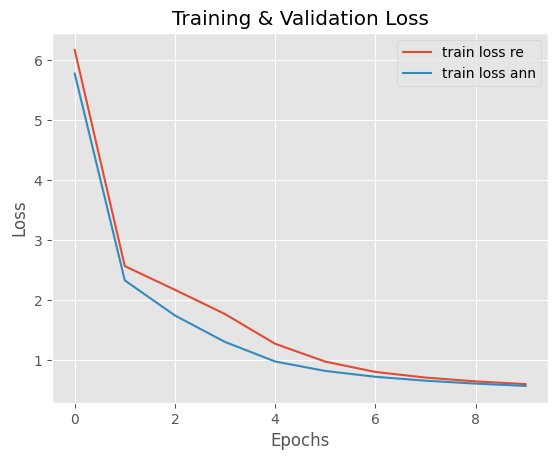

<Figure size 2000x2000 with 0 Axes>

In [ ]:
N = config.EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), avg_train_loss_list_re, label="train loss re")
plt.plot(np.arange(0, N), avg_train_loss_list_ann, label="train loss ann")

plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.figure(figsize = (20,20))
plt.show()

##### Save the Model to Drive

In [ ]:
! cp -r /content/T5model_single_column_MTL.pt /content/drive/MyDrive/'Colab Notebooks'/Databases/T5_models

#### Check Validation in the respective dataloaders

In [ ]:
val_micro_f1_score , avg_val_loss =  val(model, val_dataloader_re, criterion,'re',my_dict_re)

Val loss: 0.5209198868011727
Val accuracy: 0.6731034482758621
Val micro f1 score: 0.7589612289685442


In [ ]:
val_micro_f1_score , avg_val_loss =  val(model, val_dataloader_ann, criterion,'ann',my_dict_ann)

Val loss: 0.5327276687752059
Val accuracy: 0.39966666666666667
Val micro f1 score: 0.6689673022172375
